In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lightkurve as lk
import exoplanet as xo

starry.config.lazy = True
starry.config.quiet = True
np.random.seed(1)

import warnings

# Ignore all warnings (not recommended, might hide other important warnings)
warnings.filterwarnings("ignore")

# Ignore specific warning by type
warnings.filterwarnings("ignore", message="Cannot construct a scalar test value from a test value with no size")

# Set logging level to ignore these warnings (recommended)
import logging
logger = logging.getLogger("theano.tensor.opt")
logger.setLevel(logging.ERROR)


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
%matplotlib inline

In [3]:
import sys
sys.path.insert(1, '/Users/sabina/Desktop/GitHub/starry-project/scripts')

from starry_starry_process import StarryStarryProcess

In [4]:
def gp_model(ts, fluxes, sigma_fluxes, params):
    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
            
        else:
            return param["truth"]
    
    starry.config.lazy = True
        
    with pm.Model() as model:

        prot = parameter('star.prot')

        porb = parameter('planet.porb')
        t0 = parameter('planet.t0')
        rp = parameter('planet.r')
        planet_inc = parameter('planet.inc')
        mp = parameter('planet.m')
        ecc = parameter('planet.ecc')
        Omega = parameter('planet.Omega')
        w = parameter('planet.w')

        map_model = starry.Map(ydeg=15, udeg=2)

        stellar_inc, stellar_obl = Stellar_Ori()
        # map_model.inc = parameter('star.inc')
        # map_model.obl = parameter('star.obl')
        map_model.inc = stellar_inc
        map_model.obl = stellar_obl
        
        map_model[1] = parameter('star.u1')
        map_model[2] = parameter('star.u2')
        
        pri_model = starry.Primary(map_model, 
            r=parameter('star.r'), 
            m=parameter('star.m'), 
            prot=prot)

        sec_model = starry.kepler.Secondary(starry.Map(0,0), 
            t0=t0, 
            r=rp, 
            m=mp, 
            porb=porb, 
            ecc=ecc, 
            Omega=Omega, 
            inc=planet_inc,
            w=w)
    
        sys_model = starry.System(pri_model, sec_model)

        sp_model = StarryProcess(
            a = parameter("gp.a"),
            b = parameter("gp.b"),
            c = parameter("gp.c"),
            r = parameter("gp.r"),
            n = parameter("gp.n"),
            ydeg = 15,
        )
        
        K00 = 0.
        K01 = 10.
        K10 = np.log(0.5)
        K11 = 10.
        alpha = tt.exp(K00 + (K10 - K00) * sp_model.a)
        beta = tt.exp(K10 + (K11 - K10) * sp_model.b) 

        pm.Deterministic('sp.mu', alpha / (alpha + beta) * 180 / np.pi)
        pm.Deterministic('sp.var', alpha * beta / (tt.square(alpha + beta) * (alpha + beta + 1)) * 180 / np.pi)

        for i in range(len(ts)):
            ssp_model = StarryStarryProcess(sys_model, sp_model)
            ssp_model.compute(ts[i], fluxes[i], sigma_fluxes[i])

            pm.Deterministic(f'flux_model_{i}', tt.dot(ssp_model.design_matrix, ssp_model.sample_ylm_conditional(ts[i], fluxes[i], sigma_fluxes[i])[0]))
            pm.Deterministic(f'max_map_{i}', ssp_model._a)
            
            pm.Potential(f'marginal_likelihood_{i}', ssp_model.marginal_likelihood(ts[i], fluxes[i], sigma_flux=sigma_fluxes[i]))


    return model

In [5]:
def bin_out_of_transit(t, flux, err, params, dt=0.06, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

## Get a light curve

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

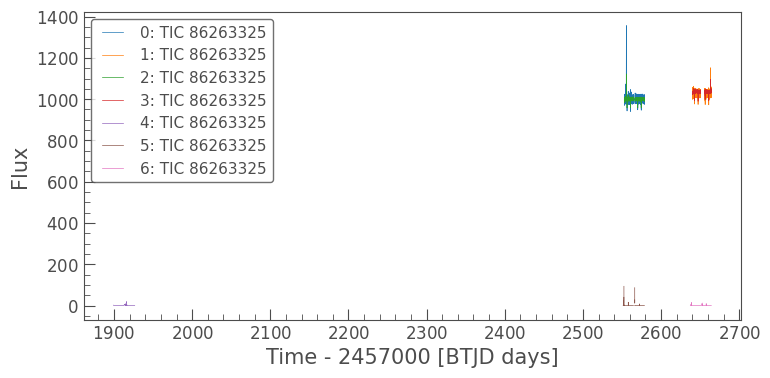

In [6]:
search_result = lk.search_lightcurve('TOI 3884')
lc_collection = search_result.download_all()
lc_collection.plot()

In [7]:
lc_collection

LightCurveCollection of 7 objects:
    0: <TessLightCurve LABEL="TIC 86263325" SECTOR=46 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 86263325" SECTOR=49 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 86263325" SECTOR=46 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 86263325" SECTOR=49 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 86263325" SECTOR=22 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    5: <TessLightCurve LABEL="TIC 86263325" SECTOR=46 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
    6: <TessLightCurve LABEL="TIC 86263325" SECTOR=49 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

In [8]:
lc_collection[0].time.value

array([2551.56457604, 2551.56596505, 2551.56735406, ..., 2578.69916336,
       2578.70055237, 2578.70194138])

In [9]:
lc_collection[1].time.value

array([2637.47827863, 2637.47966756, 2637.48105648, ..., 2664.31742913,
       2664.31881799, 2664.32020686])

In [10]:
lc_collection[2].time.value

array([2551.59235621, 2551.63402647, 2551.64097151, ..., 2578.68527324,
       2578.6922183 , 2578.69916336])

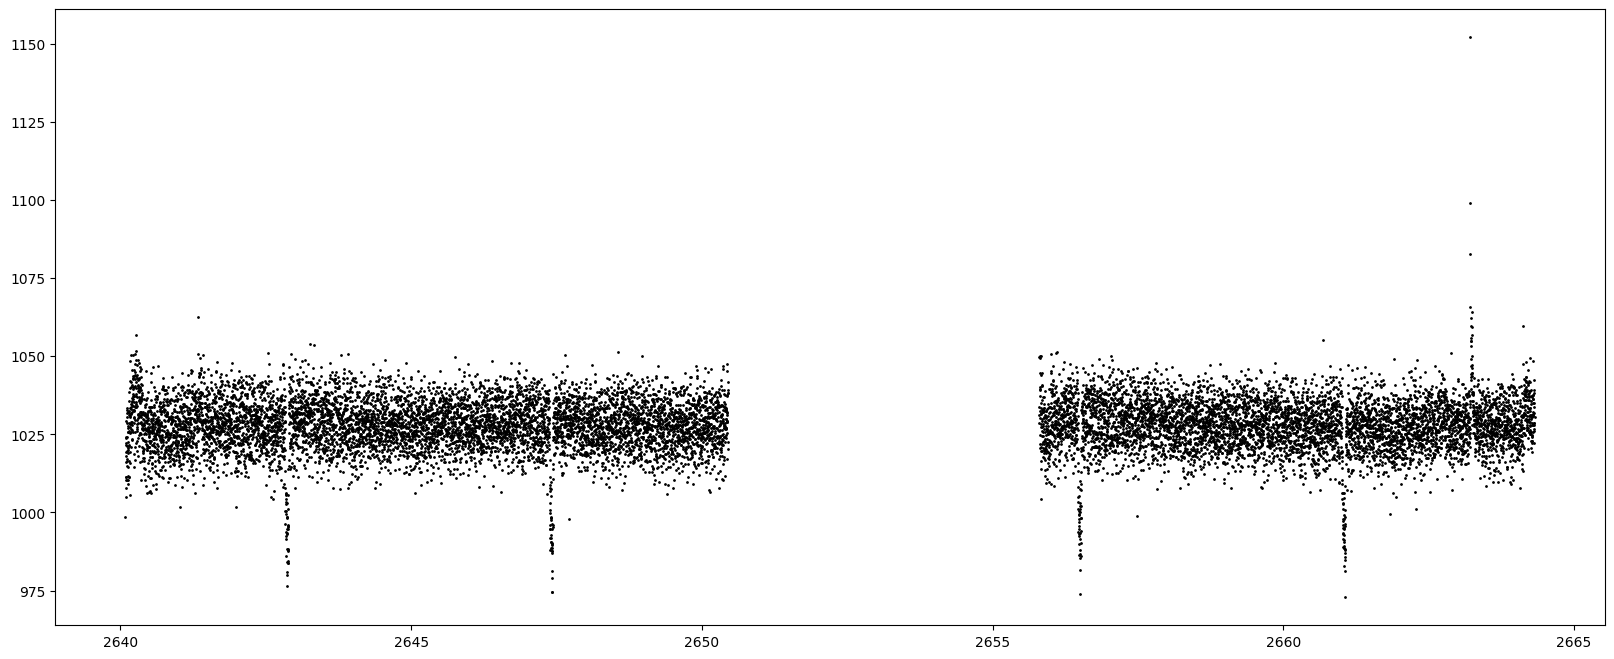

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(lc_collection[1].time.value, lc_collection[1].flux, "k.", ms=2)
# plt.xlim(1335,1335.5)
plt.show()

In [12]:
lc1 = lc_collection[0].remove_nans()
lc1 = lc1[lc1.quality == 0]

lc4 = lc_collection[1].remove_nans()
lc4 = lc4[lc4.quality == 0]

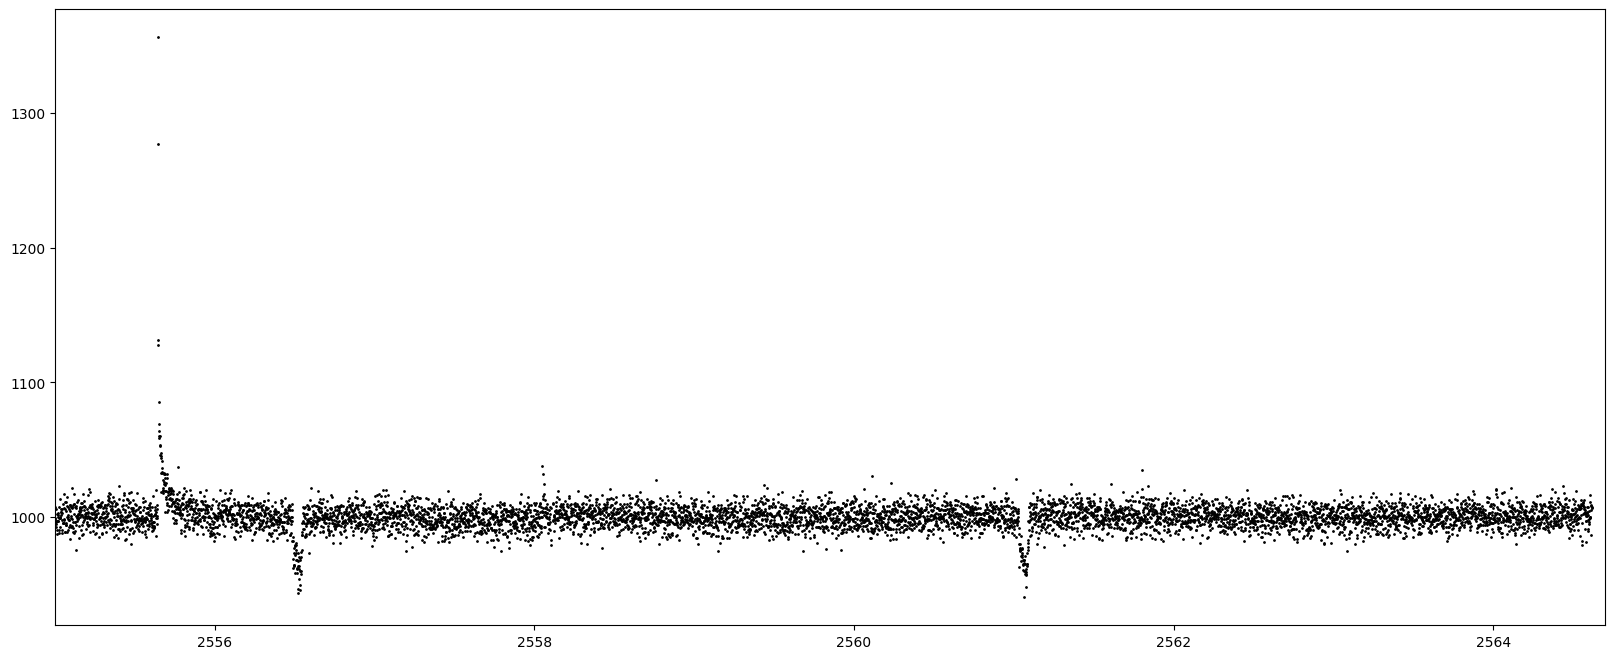

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(lc1.time.value, lc1.flux, "k.", ms=2)
plt.xlim(2555,2564.7)
plt.show()

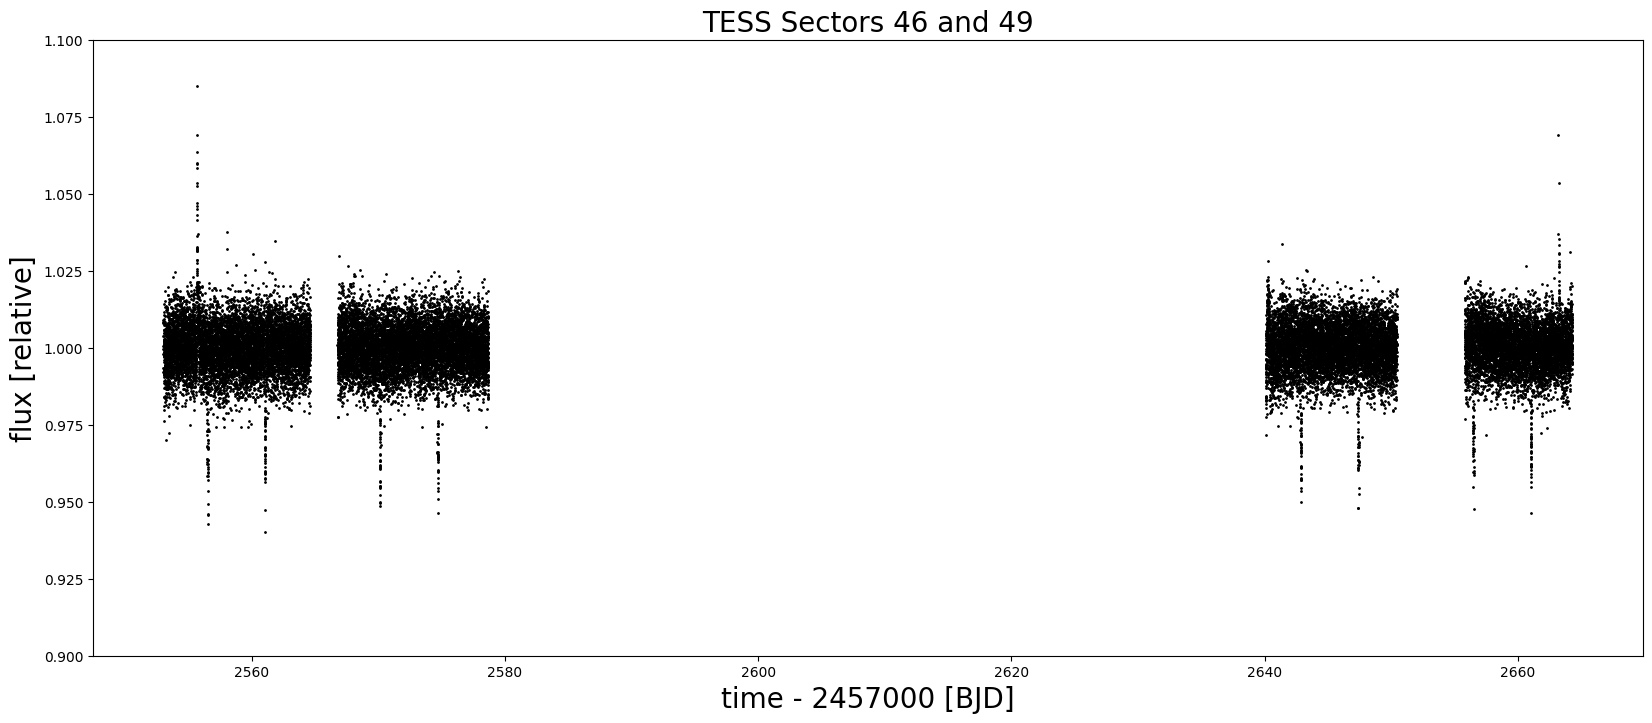

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(lc1.time.value, lc1.flux / np.mean(lc1.flux), "k.", ms=2)
plt.ylim(0.9,1.1)
plt.ylabel("Relative Flux", fontsize=20)
plt.xlabel("Time - 2457000 [BJD]", fontsize=20)
# plt.legend(fontsize=16)
plt.plot(lc4.time.value, lc4.flux / np.mean(lc4.flux), "k.", ms=2)
plt.ylim(0.9,1.1)
plt.ylabel("flux [relative]", fontsize=20)
plt.xlabel("time - 2457000 [BJD]", fontsize=20)
# plt.legend(fontsize=16)
plt.title("TESS Sectors 46 and 49", fontsize=20)
# plt.show()
plt.savefig("/Users/sabina/Desktop/GitHub/polka-dotted-stars-hatp11/src/tex/figures/toi3884-lc.pdf", bbox_inches="tight", dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


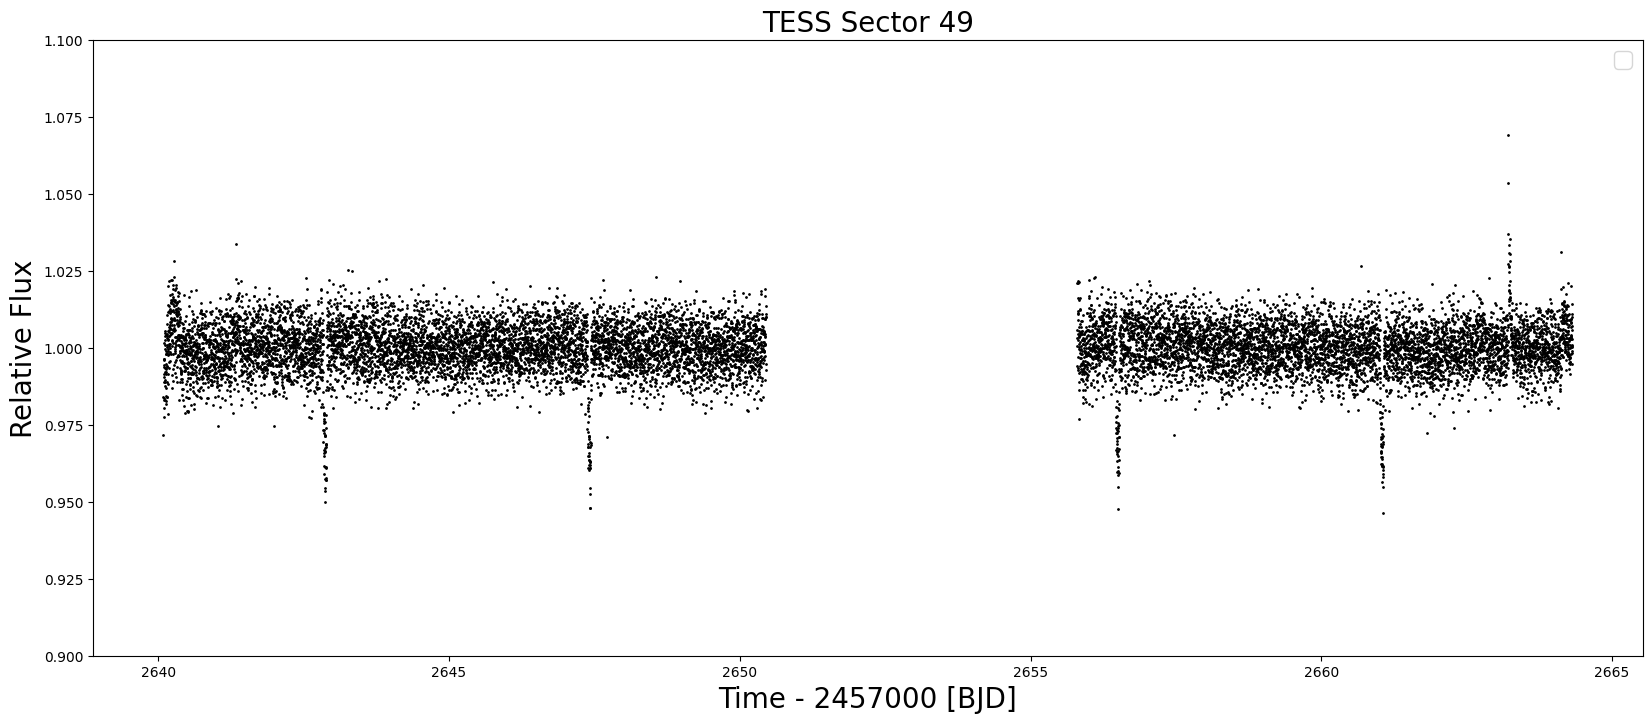

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(lc4.time.value, lc4.flux / np.mean(lc4.flux), "k.", ms=2)
plt.ylim(0.9,1.1)
plt.ylabel("Relative Flux", fontsize=20)
plt.xlabel("Time - 2457000 [BJD]", fontsize=20)
plt.legend(fontsize=16)
plt.title("TESS Sector 49", fontsize=20)
plt.show()
plt.savefig("/Users/sabina/Desktop/GitHub/polka-dotted-stars-hatp11/src/tex/figures/toi3884-sector49lc.pdf", bbox_inches="tight", dpi=300)

In [16]:
np.where(lc1.time.value > 2564.7)

(array([ 8336,  8337,  8338, ..., 16911, 16912, 16913]),)

In [17]:
chunk_times = []
chunk_fluxes = []
chunk_sigmas = []
chunk_times.append(lc1.time.value[:8336])
chunk_fluxes.append(np.ascontiguousarray(lc1.flux, dtype=np.float64)[:8336] / np.array(np.mean(lc1.flux)))
chunk_sigmas.append(np.ascontiguousarray(lc1.flux_err, dtype=np.float64)[:8336] / np.array(np.mean(lc1.flux)))

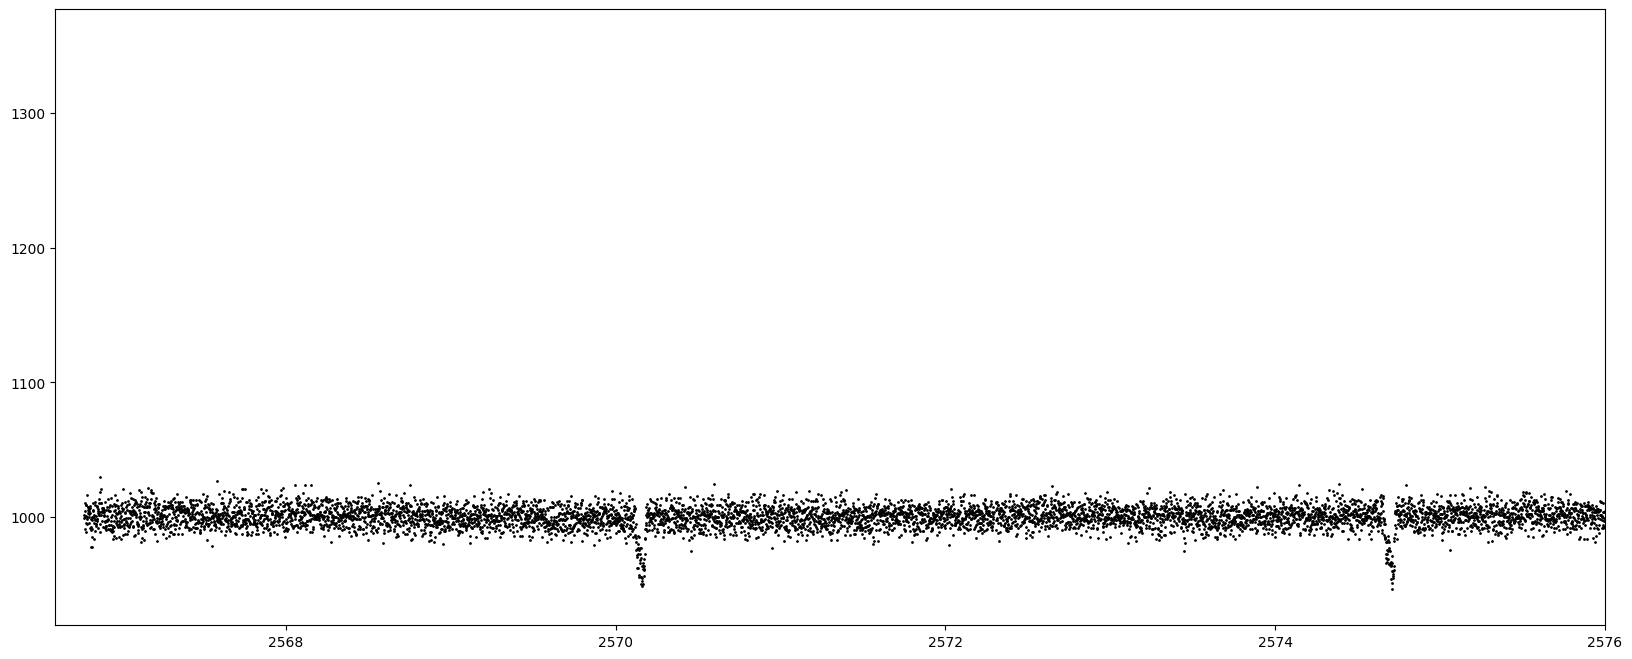

In [18]:
plt.figure(figsize=(20, 8))
plt.plot(lc1.time.value, lc1.flux, "k.", ms=2)
plt.xlim(2566.6,2576)
plt.show()

In [19]:
np.where(lc1.time.value>2566.6)

(array([ 8336,  8337,  8338, ..., 16911, 16912, 16913]),)

In [20]:
chunk_times.append(lc1.time.value[8336:])
chunk_fluxes.append(np.ascontiguousarray(lc1.flux, dtype=np.float64)[8336:] / np.array(np.mean(lc1.flux)))
chunk_sigmas.append(np.ascontiguousarray(lc1.flux_err, dtype=np.float64)[8336:] / np.array(np.mean(lc1.flux)))

In [21]:
total_t = np.concatenate((lc1.time.value, lc4.time.value))
total_flux = np.concatenate((np.ascontiguousarray(lc1.flux, dtype=np.float64)/ np.array(np.mean(lc1.flux)), np.ascontiguousarray(lc4.flux, dtype=np.float64)/ np.array(np.mean(lc4.flux))))
total_sigma = np.concatenate((np.ascontiguousarray(lc1.flux_err, dtype=np.float64)/ np.array(np.mean(lc1.flux)), np.ascontiguousarray(lc4.flux_err, dtype=np.float64)/ np.array(np.mean(lc4.flux))))

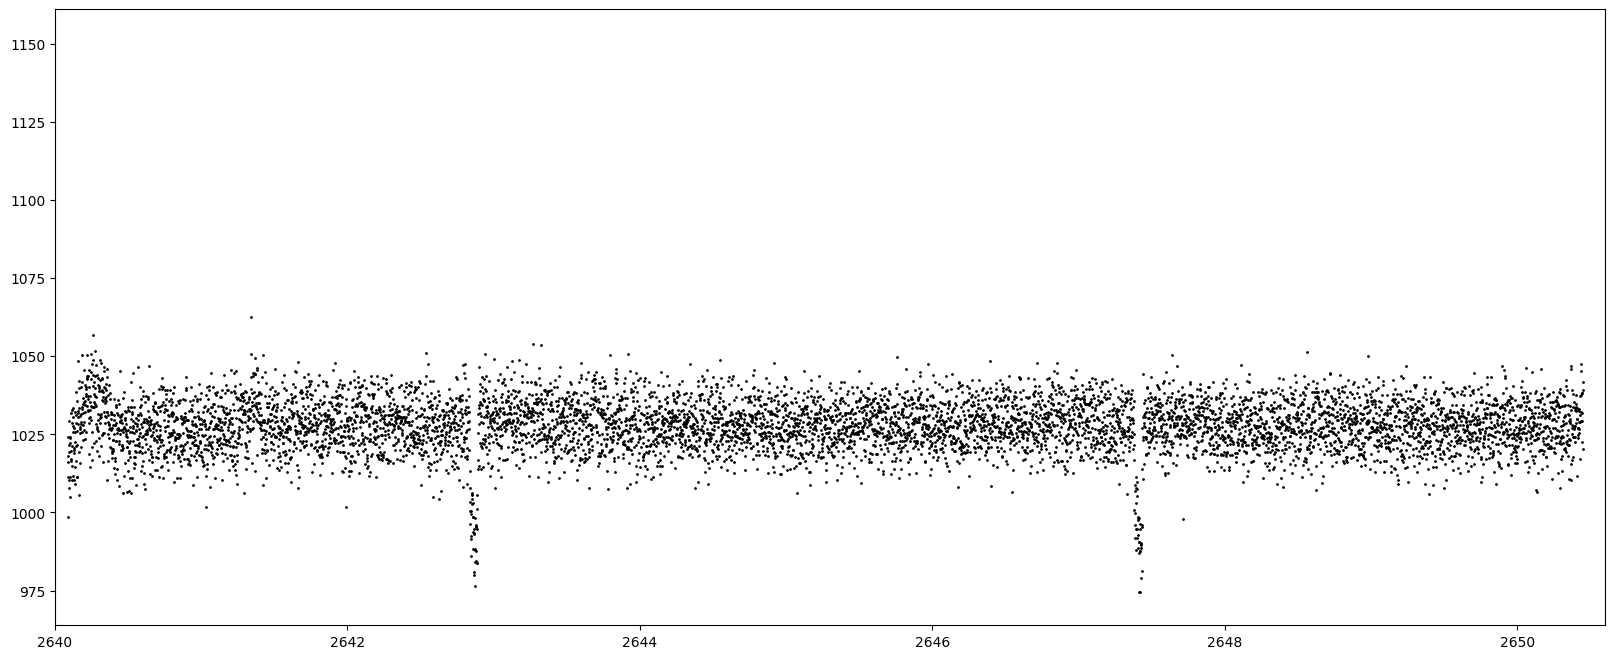

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(lc_collection[1].time.value, lc_collection[1].flux, "k.", ms=2)
plt.xlim(2640,2650.6)
plt.show()

In [23]:
np.where(lc4.time.value>2650.6)

(array([ 7454,  7455,  7456, ..., 13578, 13579, 13580]),)

In [24]:
chunk_times.append(lc4.time.value[:7454])
chunk_fluxes.append(np.ascontiguousarray(lc4.flux, dtype=np.float64)[:7454] / np.array(np.mean(lc4.flux)))
chunk_sigmas.append(np.ascontiguousarray(lc4.flux_err, dtype=np.float64)[:7454] / np.array(np.mean(lc4.flux)))

chunk_times.append(lc4.time.value[7454:])
chunk_fluxes.append(np.ascontiguousarray(lc4.flux, dtype=np.float64)[7454:] / np.array(np.mean(lc4.flux)))
chunk_sigmas.append(np.ascontiguousarray(lc4.flux_err, dtype=np.float64)[7454:] / np.array(np.mean(lc4.flux)))

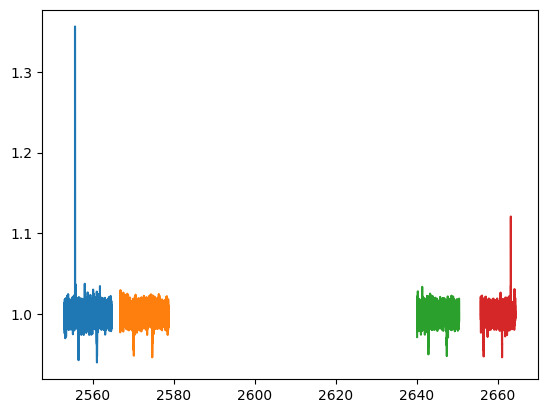

In [25]:
for i in range(len(chunk_times)):
    plt.plot(chunk_times[i], chunk_fluxes[i])

In [26]:
def remove_flares(t, flux, flux_err, window_size=100, sigma=1e-4):
    t_clean = []
    flux_clean = []
    flux_err_clean = []

    for i in range(len(t)):
        start = max(0, i - window_size // 2)
        end = min(len(t), i + window_size // 2)

        mean = np.mean(flux[start:end])
        std = np.std(flux[start:end])

        threshold = 1.025 #mean + sigma * std
        # print(threshold)

        if flux[i] < threshold:
            t_clean.append(t[i])
            flux_clean.append(flux[i])
            flux_err_clean.append(flux_err[i])

    t_clean = np.array(t_clean)
    flux_clean = np.array(flux_clean)
    flux_err_clean = np.array(flux_err_clean)

    return t_clean, flux_clean, flux_err_clean

t_clean, flux_clean, flux_err_clean = remove_flares(chunk_times[3], chunk_fluxes[3], chunk_sigmas[3])

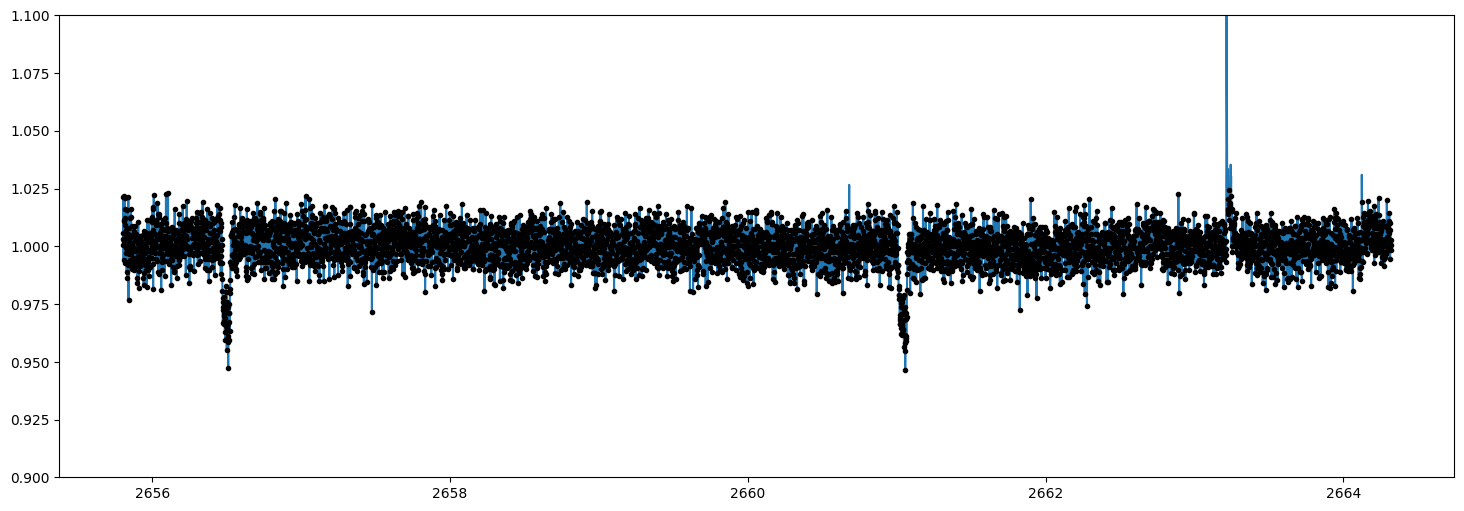

In [27]:
plt.figure(figsize=(18,6))
plt.plot(chunk_times[3], chunk_fluxes[3])
plt.plot(t_clean, flux_clean, 'k.')
# plt.xlim(2040,2042)
plt.ylim(0.9,1.1)
plt.show()

In [28]:
for i in range(len(chunk_times)):
    chunk_times[i], chunk_fluxes[i], chunk_sigmas[i] = remove_flares(chunk_times[i], chunk_fluxes[i], chunk_sigmas[i])

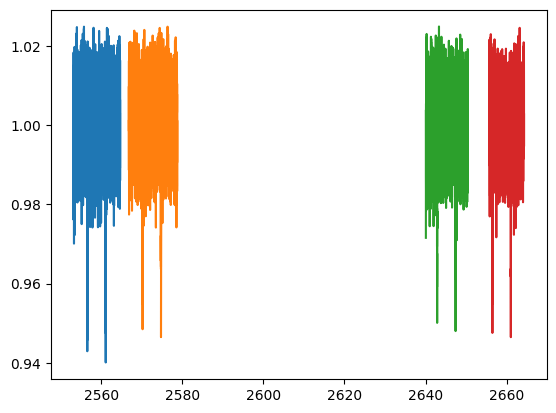

In [29]:
for i in range(len(chunk_times)):
    plt.plot(chunk_times[i], chunk_fluxes[i])

In [30]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )

def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)

def Planet_Inc(name, *args, **kwargs):
    bmax = params[name].get('bmax')
    b = pm.Uniform('b', -bmax, bmax)
    planet_inc = pm.Deterministic(name, 180.0/np.pi*np.arccos(b))
    
    return planet_inc

def Planet_w(name, *args, **kwargs):
    w_x = pm.Normal('w_x', mu=0, sigma=1, testval=1)
    w_y = pm.Normal('w_y', mu=0, sigma=1, testval=1)
    planet_w = pm.Deterministic(name, 180.0/np.pi*tt.arctan2(w_y, w_x))
    
    return planet_w

def xyz_transform(x_, y_, z_):
    x = x_
    y = (np.sqrt(2)/2) * (z_ + y_)
    z = (np.sqrt(2)/2) * (z_ - y_)

    return x, y, z

def xyz_transform_back(x, y, z):
    x_ = x
    y_ = (np.sqrt(2)/2) * (y - z)
    z_ = (np.sqrt(2)/2) * (y + z)

    return x_, y_, z_

def Stellar_Ori():
    stellar_ori_x_ = pm.Normal('stellar_ori_x_', mu=0, sigma=1, testval=1)
    stellar_ori_y_ = pm.Normal('stellar_ori_y_', mu=0, sigma=1, testval=1)
    stellar_ori_z_ = pm.HalfNormal('stellar_ori_z_', sigma=1, testval=1)

    stellar_ori_x, stellar_ori_y, stellar_ori_z = xyz_transform(stellar_ori_x_, stellar_ori_y_, stellar_ori_z_)

    stellar_obl = pm.Deterministic('star.obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
    stellar_inc = pm.Deterministic('star.inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
    
    return stellar_inc, stellar_obl
    # if "inc" in name:
    #     return stellar_inc
    
    # elif "obl" in name:
    #     return stellar_obl

def Period(name, *args, **kwargs):
    Ttotal = t[-1] - t[0]
    frac_bounds = params[name].get('frac_bounds')

    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]

    def logp(trueval, frac_bounds):
        return pm.Uniform(name+'logp',tt.log(trueval) + np.log1p(-frac_bounds), tt.log(trueval) + np.log1p(frac_bounds))

    period = pm.Deterministic(name, tt.exp(logp(trueval, frac_bounds)))

    return period

def Logarithmic(name, *args, **kwargs):
    if kwargs.get("testval", None) is not None:
        trueval = kwargs["testval"]
    log_rp = pm.Uniform(name+'log', tt.log(trueval/2), tt.log(2*trueval))
    rp = pm.Deterministic(name, tt.exp(log_rp))

    return rp

# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [31]:
mSun = 1.989e33 # grams
mJ = 1.898e30 
rJ = 6.99e6 # cm
rSun = 69.634e6

mTOI3884 = 0.2813 * mSun
mTOI3884b = 0.0519 * mJ # grams
rTOI3884 = 0.3043 * rSun 
rTOI3884b = 0.535 * rJ # cm

In [32]:
mTOI3884 / mSun

0.2813

In [33]:
# True parameters & priors
params = {
    "planet.inc": {"truth": 85.85844557321126, "dist": Planet_Inc},
    "planet.ecc": {"truth": 0.48181713192128145, "dist": Uniform, "args": [0.0, 1.]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.544592163539594, "dist": Period},
    "planet.t0": {"truth": 2556.516, "dist": Uniform, "args": [2556, 2557]},
    "planet.r": {"truth": 0.1746426230950171, "dist": Logarithmic},
    "planet.m": {"truth":  mTOI3884b / mTOI3884, "dist": Uniform, "args": [4e-5, 4e-4]},
    "planet.w": {"truth": 190, "dist": Planet_w},

    "star.inc": {"truth": 115.45005374162783, "dist": Stellar_Ori},
    "star.m": {"truth": 1, "dist": Uniform, "args": [0.1, 0.3]},
    "star.u1": {"truth": 0.2886379996338223, "dist": Uniform, "args": [0.0, 0.5]},
    "star.u2": {"truth": 0.08500237661869868, "dist": Uniform, "args": [0.0, 0.2]},
    "star.prot": {"truth": 18, "dist": Period},
    "star.obl": {"truth": 62.31482288062067, "dist": Stellar_Ori},
    "star.r": {"truth": 1, "dist": Uniform, "args": [0.1, 0.4]},

    "gp.r": {"truth": 11.609196393800204, "dist": Uniform, "args": [10.0, 60.0]},
    "gp.c": {"truth": 0.4132101747490784, "dist": Uniform, "args": [0.1, 0.9]},
    "gp.n": {"truth": 3.3160051258826533, "dist": Uniform, "args": [0, 10]},
    "gp.a": {"truth": 0.023205943718544994, "dist": Uniform, "args": [0.0, 1.]},
    "gp.b": {"truth": 0.19272121091080988, "dist": Uniform, "args": [0.0, 1.]}
}

In [34]:
for i in range(len(chunk_times)):
    chunk_times[i], chunk_fluxes[i], chunk_sigmas[i] = bin_out_of_transit(chunk_times[i], chunk_fluxes[i], chunk_sigmas[i], params, dt=0.05, binsize=100)

In [35]:
t = np.concatenate(chunk_times)
flux_obs = np.concatenate(chunk_fluxes)
sigma_flux = np.concatenate(chunk_sigmas)

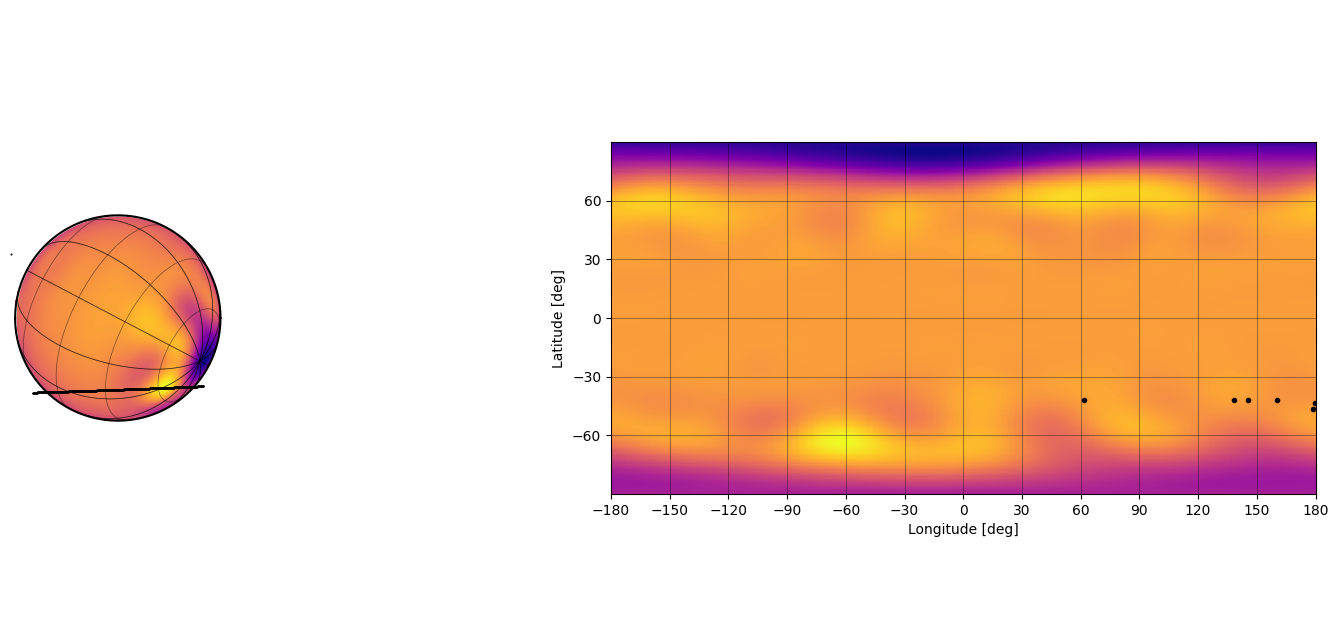

In [36]:
# Ttr_half = 0.1
# dt_in_transit = Ttr_half / 20.0
# dt_out_transit = params['star.prot']['truth'] / 20.0

# dt = 0.6
# idx = np.zeros(len(t_), dtype=bool)
# ntransits = int(np.ceil(t_[-1] / params["planet.porb"]["truth"]))
# for n in range(ntransits):
#     t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
#     idx |= ((t_ > t0 - dt) & (t_ < t0 + dt))
# t_in = t_[idx]
# t_out = t_[~idx]
# flux_in = flux_[idx]
# flux_out = flux_[~idx]

# nt = len(t)

Ttotal = t[-1] - t[0]

# Setting the priors
# fraction bounds for period priors
prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/100, 0.25)
porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/100, 0.25)

# Let's add this parameter to the parameter dictionary as a prior
params['star.prot']['frac_bounds'] = prot_frac_bounds
params['planet.porb']['frac_bounds'] = porb_frac_bounds

# semi-major axis
a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = params['star.r']['truth'] / a

# Let's add this parameter to the parameter dictionary as a prior
params['planet.inc']['bmax'] = bmax

# Plot the data

map = starry.Map(15, 2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
planet = starry.Secondary(
    starry.Map(0,0),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
    r=params["planet.r"]["truth"],
    m=params["planet.m"]["truth"],
    w=params["planet.w"]["truth"],
)

sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]
theta = (360 * t / params["star.prot"]["truth"]) % 360

# *** Draw 1 sample from the GP
sp = StarryProcess(
    a=params["gp.a"]["truth"],
    b=params["gp.b"]["truth"],
    r=params["gp.r"]["truth"],
    c=params["gp.c"]["truth"],
    n=params["gp.n"]["truth"],
)

y_true = sp.sample_ylm().eval().reshape(-1)
y_true[0] += 1

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
map[:, :] = y_true
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
ax[1].plot(lon, lat + mask, "k.");

In [ ]:
planet.t0.eval()

array(2556.516)

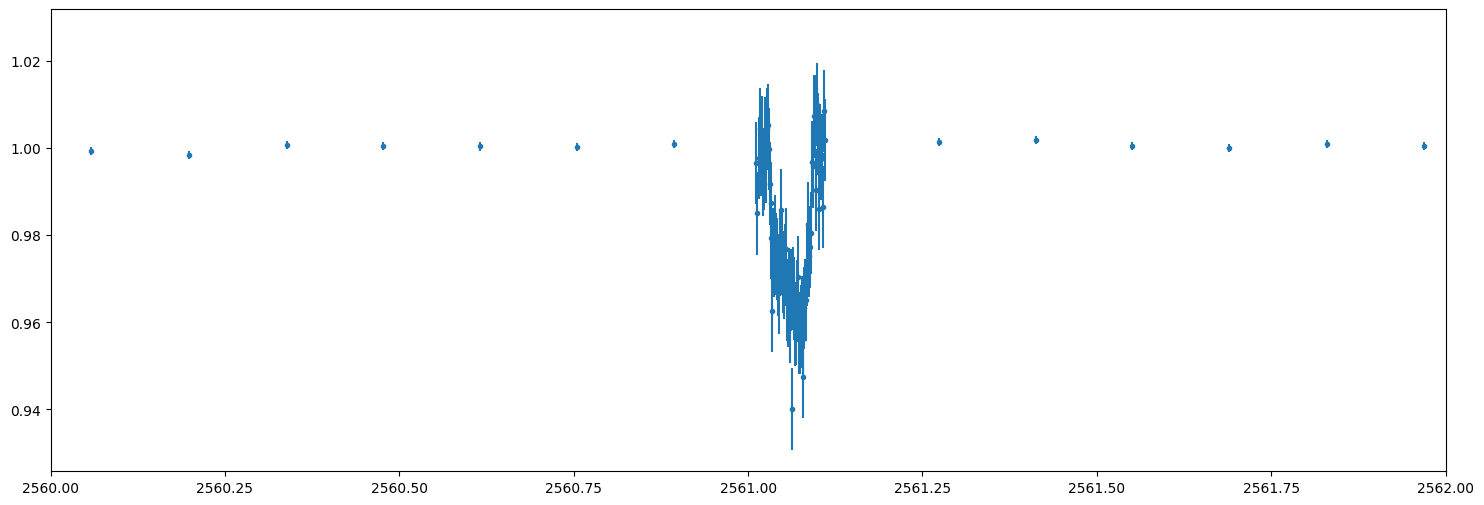

In [ ]:
plt.figure(figsize=(18,6))
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
# plt.plot(t, ssp.design_matrix @ y_true)
plt.xlim(2560,2562)
plt.show()

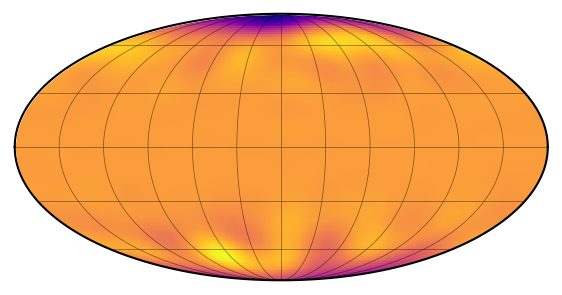

In [40]:
sp.visualize(y_true)

In [41]:
len(chunk_fluxes)

4

In [42]:
ssp = StarryStarryProcess(sys, sp)

# Inference

In [125]:
# Set some free params & get the model
p = dict(params)

# p['planet.porb']['free'] = True
# p['planet.t0']['free'] = True
# p['planet.r']['free'] = True
p['planet.inc']['free'] = True
p['planet.ecc']['free'] = True
# p['planet.w']['free'] = True

# p['star.u1']['free'] = True
# p['star.u2']['free'] = True

# p['gp.c']['free'] = True
# p['gp.a']['free'] = True
# p['gp.b']['free'] = True
# p['gp.r']['free'] = True
# p['gp.n']['free'] = True

# p['star.inc']['free'] = True
# p['star.obl']['free'] = True
# p['star.prot']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]

In [44]:
def get_free_param_names(params):
    return [name for name, param in params.items() 
            if param.get("free", False)]

In [90]:
def unpack_params(theta, params):
    param_dict = {}
    idx = 0
    for name, param in params.items():
        if param.get("free", False):
            param_dict[name] = theta[idx]
            idx += 1
        else:
            param_dict[name] = param["truth"]
    return param_dict

In [95]:
from scipy import stats
def isotropic_inclination_prior(x):
    """Isotropic prior for inclination angles (in degrees)"""
    return np.log(np.pi / 180 * np.sin(x * np.pi / 180))

def angle_prior(x):
    """Uniform prior for angles in [-180, 180)"""
    if -180 <= x < 180:
        return 0.0  
    return -np.inf

def planet_inc_prior(b, bmax):
    """Prior for planet inclination based on impact parameter"""
    if -bmax <= b <= bmax:
        return 0.0
    return -np.inf

def planet_w_prior(w):
    """Prior for planet argument of periastron using x-y parameterization"""
    # Since this comes from normal distributions in x-y, just use normal prior
    return stats.norm.logpdf(np.cos(w * np.pi / 180)) + stats.norm.logpdf(np.sin(w * np.pi / 180))

def stellar_ori_prior(inc, obl):
    """Prior for stellar orientation using x-y-z parameterization"""
    inc_rad = inc * np.pi / 180
    obl_rad = obl * np.pi / 180
    
    z = np.cos(inc_rad)
    xy = np.sin(inc_rad)
    x = xy * np.cos(obl_rad)
    y = xy * np.sin(obl_rad)
    
    x_, y_, z_ = xyz_transform_back(x, y, z)
    
    log_prob = (stats.norm.logpdf(x_) + 
                stats.norm.logpdf(y_) + 
                stats.halfnorm.logpdf(z_))
    
    return log_prob

def period_prior(P, P_true, frac_bounds):
    """Log-uniform prior within fractional bounds of true period"""
    log_P = np.log(P)
    log_P_true = np.log(P_true)
    if (log_P_true + np.log1p(-frac_bounds) <= log_P <= 
        log_P_true + np.log1p(frac_bounds)):
        return 0.0  # log(1) = 0 for uniform distribution in log space
    return -np.inf

def logarithmic_prior(val, true_val):
    """Log-uniform prior within factor of 2 of true value"""
    if true_val/2 <= val <= 2*true_val:
        return 0.0  # log(1) = 0 for uniform distribution in log space
    return -np.inf

def log_prior(theta, params):
    """Calculate total log prior probability"""
    param_dict = unpack_params(theta, params)
    log_prior = 0.0
    
    # Planet parameters
    log_prior += planet_inc_prior(np.cos(param_dict['planet.inc'] * np.pi / 180), 
                                params['planet.inc'].get('bmax'))
    log_prior += stats.uniform.logpdf(param_dict['planet.ecc'], 0, 1)
    log_prior += angle_prior(param_dict['planet.Omega'])
    log_prior += period_prior(param_dict['planet.porb'], 
                            params['planet.porb']['truth'],
                            params['planet.porb'].get('frac_bounds', 0.1))
    log_prior += stats.uniform.logpdf(param_dict['planet.t0'], 2556, 1)
    log_prior += logarithmic_prior(param_dict['planet.r'], 
                                 params['planet.r']['truth'])
    log_prior += stats.uniform.logpdf(param_dict['planet.m'], 4e-5, 4e-4-4e-5)
    log_prior += planet_w_prior(param_dict['planet.w'])
    
    # Stellar parameters
    stellar_ori = stellar_ori_prior(param_dict['star.inc'], 
                                  param_dict['star.obl'])
    log_prior += stellar_ori
    log_prior += stats.uniform.logpdf(param_dict['star.m'], 0.1, 0.2)
    log_prior += stats.uniform.logpdf(param_dict['star.u1'], 0, 0.5)
    log_prior += stats.uniform.logpdf(param_dict['star.u2'], 0, 0.2)
    log_prior += period_prior(param_dict['star.prot'],
                            params['star.prot']['truth'],
                            params['star.prot'].get('frac_bounds', 0.1))
    log_prior += stats.uniform.logpdf(param_dict['star.r'], 0.1, 0.3)
    
    # GP parameters
    log_prior += stats.uniform.logpdf(param_dict['gp.r'], 10.0, 50.0)
    log_prior += stats.uniform.logpdf(param_dict['gp.c'], 0.1, 0.8)
    log_prior += stats.uniform.logpdf(param_dict['gp.n'], 0, 10)
    log_prior += stats.uniform.logpdf(param_dict['gp.a'], 0, 1)
    log_prior += stats.uniform.logpdf(param_dict['gp.b'], 0, 1)
    
    return log_prior

In [135]:
def log_likelihood(theta, ts, fluxes, sigma_fluxes, params):
    """Calculate log likelihood"""
    param_dict = unpack_params(theta, params)
    
    starry.config.lazy = False  
    
    map_model = starry.Map(ydeg=15, udeg=2)
    
    map_model.inc = param_dict['star.inc']
    map_model.obl = param_dict['star.obl']
    
    map_model[1] = param_dict['star.u1']
    map_model[2] = param_dict['star.u2']
    
    pri_model = starry.Primary(
        map_model,
        r=param_dict['star.r'],
        m=param_dict['star.m'],
        prot=param_dict['star.prot']
    )
    
    sec_model = starry.kepler.Secondary(
        starry.Map(0,0),
        t0=param_dict['planet.t0'],
        r=param_dict['planet.r'],
        m=param_dict['planet.m'],
        porb=param_dict['planet.porb'],
        ecc=param_dict['planet.ecc'],
        Omega=param_dict['planet.Omega'],
        inc=param_dict['planet.inc'],
        w=param_dict['planet.w']
    )
    
    sys_model = starry.System(pri_model, sec_model)
    
    sp_model = StarryProcess(
        a=param_dict["gp.a"],
        b=param_dict["gp.b"],
        c=param_dict["gp.c"],
        r=param_dict["gp.r"],
        n=param_dict["gp.n"],
        ydeg=15
    )
    
    K00, K01 = 0.0, 10.0
    K10, K11 = np.log(0.5), 10.0
    alpha = np.exp(K00 + (K10 - K00) * sp_model.a)
    beta = np.exp(K10 + (K11 - K10) * sp_model.b)
    
    log_like = 0
    
    for i in range(len(ts)):
        ssp_model = StarryStarryProcess(sys_model, sp_model)
        ssp_model.compute(ts[i], fluxes[i], sigma_fluxes[i])
        
        log_like += ssp_model.marginal_likelihood(
            ts[i], 
            fluxes[i], 
            sigma_flux=sigma_fluxes[i]
        )
        
    return log_like

In [ ]:
import itertools
likelihood = lambda x: log_likelihood(x, chunk_times, chunk_fluxes, chunk_sigmas, dict(itertools.islice(params.items(), 2)))

In [97]:
free

['planet.inc',
 'planet.ecc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'planet.w',
 'star.inc',
 'star.u1',
 'star.u2',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.n',
 'gp.a',
 'gp.b']

In [37]:
# True parameters & priors
truths = {
    "planet.inc": 85.85844557321126,
    "planet.ecc": 0.48181713192128145, 
    "planet.Omega": 0.0,
    "planet.porb": 4.544592163539594,
    "planet.t0": 2556.516,
    "planet.r": 0.1746426230950171,
    "planet.m": mTOI3884b / mTOI3884, 
    "planet.w": 190,

    "star.inc": 115.45005374162783,
    "star.m": 1,
    "star.u1": 0.2886379996338223,
    "star.u2": 0.08500237661869868,
    "star.prot": 18, 
    "star.obl": 62.31482288062067, 
    "star.r": 1,

    "gp.r": 11.609196393800204, 
    "gp.c": 0.4132101747490784,
    "gp.n": 3.3160051258826533, 
    "gp.a": 0.023205943718544994, 
    "gp.b": 0.19272121091080988, 
}

In [38]:
# the order: [impact parameter, eccentricity, log_porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, log_prot, gp.r, gp.c, gp.n, gp.a, gp.b]

In [38]:
def inv_logit(x, a, b):
    y = 1/(1 + np.exp(-x))
    return a + (b-a)*y

def logit(y, a, b):
    yy = (b-y)/(b-a)
    return np.log1p(-yy) -np.log(yy)

def log_jacobian_inv_logit(y, x, a, b):
    # dy/dx = 1/(1+exp(-x))^2 * exp(-x) = y^2 exp(-x)
    return np.log(b-a) + 2*np.log(y) - x

# Planetary inclination
# semi-major axis
a = (truths['star.m']*np.square(truths['planet.porb']/365.25))**(1/3) * 215.03 # Solar radii
# impact parameter
bmax = truths['star.r'] / a

def unpack_parameters(xs, return_logjac=False):
    logjac = 0.0

    impact_parameter_logit, eccentricity_logit, f_porb_logit, f_t0_logit, w_x, w_y, stellar_x_, stellar_y_, stellar_z__log, u1_logit, u2_logit, f_prot_logit, gp_r_logit, gp_c_logit, gp_n_logit, gp_a_logit, gp_b_logit = xs

    impact_parameter = inv_logit(impact_parameter_logit, -bmax, bmax)
    if return_logjac:
        logjac += log_jacobian_inv_logit(impact_parameter, impact_parameter_logit, -bmax, bmax)

    eccentricity = inv_logit(eccentricity_logit, 0, 1)
    if return_logjac:
        logjac += log_jacobian_inv_logit(eccentricity, eccentricity_logit, 0, 1)

    f_porb = inv_logit(f_porb_logit, 0.99, 1.01)
    if return_logjac:
        logjac += log_jacobian_inv_logit(f_porb, f_porb_logit, 0.99, 1.01)
    
    porb = truths['planet.porb']*f_porb
    if return_logjac:
        logjac += np.log(truths['planet.porb'])

    f_t0 = inv_logit(f_t0_logit, 0.9, 1.1)
    if return_logjac:
        logjac += log_jacobian_inv_logit(f_t0, f_t0_logit, 0.9, 1.1)
    
    t0 = truths['planet.t0'] + truths['planet.porb']*(f_t0-1)
    if return_logjac:
        logjac += np.log(truths['planet.porb'])

    stellar_z_ = np.exp(stellar_z__log)
    if return_logjac:
        logjac += stellar_z__log

    u1 = inv_logit(u1_logit, 0, 0.5)
    if return_logjac:
        logjac += log_jacobian_inv_logit(u1, u1_logit, 0, 0.5)

    u2 = inv_logit(u2_logit, 0, 0.2)
    if return_logjac:
        logjac += log_jacobian_inv_logit(u2, u2_logit, 0, 0.2)

    f_prot = inv_logit(f_prot_logit, 0.9, 1.1)
    if return_logjac:
        logjac += log_jacobian_inv_logit(f_prot, f_prot_logit, 0.9, 1.1)

    prot = f_prot*truths['star.prot']
    if return_logjac:
        logjac += np.log(truths['star.prot'])

    gp_r = inv_logit(gp_r_logit, 10.0, 60.0)
    if return_logjac:
        logjac += log_jacobian_inv_logit(gp_r, gp_r_logit, 10.0, 60.0)

    gp_c = inv_logit(gp_c_logit, 0.1, 0.9)
    if return_logjac:
        logjac += log_jacobian_inv_logit(gp_c, gp_c_logit, 0.1, 0.9)

    gp_n = inv_logit(gp_n_logit, 1.0, 10.0)
    if return_logjac:
        logjac += log_jacobian_inv_logit(gp_n, gp_n_logit, 1.0, 10.0)

    gp_a = inv_logit(gp_a_logit, 0.0, 1)
    if return_logjac:
        logjac += log_jacobian_inv_logit(gp_a, gp_a_logit, 0.0, 1.0)

    gp_b = inv_logit(gp_b_logit, 0.0, 1.0)
    if return_logjac:
        logjac += log_jacobian_inv_logit(gp_b, gp_b_logit, 0.0, 1.0)

    params = (impact_parameter, eccentricity, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b)
    if return_logjac:
        return params, logjac
    else:
        return params
    
def pack_parameters(pars):
    (impact_parameter, eccentricity, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b) = pars

    ip_logit = logit(impact_parameter, -bmax, bmax)
    e_logit = logit(eccentricity, 0, 1)
    f_porb_logit = logit(porb/truths['planet.porb'], 0.99, 1.01)
    f_t0_logit = logit((t0-truths['planet.t0'])/truths['planet.porb'] + 1, 0.9, 1.1)
    stellar_z__log = np.log(stellar_z_)
    u1_logit = logit(u1, 0, 0.5)
    u2_logit = logit(u2, 0, 0.2)
    f_prot_logit = logit(prot / truths['star.prot'], 0.9, 1.1)
    gp_r_logit = logit(gp_r, 10.0, 60.0)
    gp_c_logit = logit(gp_c, 0.1, 0.9)
    gp_n_logit = logit(gp_n, 1.0, 10.0)
    gp_a_logit = logit(gp_a, 0.0, 1.0)
    gp_b_logit = logit(gp_b, 0.0, 1.0)

    return (ip_logit, e_logit, f_porb_logit, f_t0_logit, w_x, w_y, stellar_x_, stellar_y_, stellar_z__log, u1_logit, u2_logit, f_prot_logit, gp_r_logit, gp_c_logit, gp_n_logit, gp_a_logit, gp_b_logit)

def lprior(x):
    logp = 0.0

    (b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b), logjac = unpack_parameters(x, return_logjac=True)

    # Flat priors on b, e, porb, t0

    # Gaussian on w_x, w_y
    logp += -0.5*(w_x*w_x + w_y*w_y)

    # Gaussian on the xyz_
    logp += -0.5*(stellar_x_*stellar_x_ + stellar_y_*stellar_y_ + stellar_z_*stellar_z_)

    # Flat on u1, u2, prot, and all the gp parameters

    return logp + logjac    

In [39]:
npar = 17
packed_pars = np.random.randn(npar)
np.abs(packed_pars - pack_parameters(unpack_parameters(packed_pars, return_logjac=False)))

array([2.22044605e-16, 3.33066907e-16, 1.33226763e-14, 2.43804976e-13,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.55111512e-17, 1.66533454e-16, 2.22044605e-16, 4.44089210e-16,
       2.22044605e-16, 1.11022302e-16, 4.44089210e-16, 4.44089210e-16,
       1.11022302e-16])

In [40]:
def log_likelihood(x):
    """Calculate log likelihood"""
    
    (b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b) = unpack_parameters(x, return_logjac=False)
    
    return log_likelihood_fn(b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b)

def log_likelihood_from_scalars(b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b): 
    map_model = starry.Map(ydeg=15, udeg=2)

    stellar_ori_x, stellar_ori_y, stellar_ori_z = xyz_transform(stellar_x_, stellar_y_, stellar_z_)
    
    map_model.inc = 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z)))
    map_model.obl = 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x)
    
    map_model[1] = u1
    map_model[2] = u2
    
    pri_model = starry.Primary(
        map_model,
        r=truths['star.r'],
        m=truths['star.m'],
        prot=prot
    )
    
    sec_model = starry.kepler.Secondary(
        starry.Map(0,0),
        t0=t0,
        r=truths['planet.r'],
        m=truths['planet.m'],
        porb=porb,
        ecc=e,
        Omega=truths['planet.Omega'],
        inc=180.0/np.pi*tt.arccos(b),
        w=180.0/np.pi*tt.arctan2(w_y, w_x)
    )
    
    sys_model = starry.System(pri_model, sec_model)
    
    sp_model = StarryProcess(
        a=gp_a,
        b=gp_b,
        c=gp_c,
        r=gp_r,
        n=gp_n,
        ydeg=15
    )
    
    log_like = 0
    
    for i in range(len(chunk_times)):
        ssp_model = StarryStarryProcess(sys_model, sp_model)
        ssp_model.compute(chunk_times[i], chunk_fluxes[i], chunk_sigmas[i])
        
        log_like += ssp_model.marginal_likelihood(
            chunk_times[i], 
            chunk_fluxes[i], 
            sigma_flux=chunk_sigmas[i]
        )
        
    return log_like

b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b = [tt.dscalar() for _ in range(17)]
log_likelihood_fn = theano.function([b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b], log_likelihood_from_scalars(b, e, porb, t0, w_x, w_y, stellar_x_, stellar_y_, stellar_z_, u1, u2, prot, gp_r, gp_c, gp_n, gp_a, gp_b))

In [41]:
test_vals = [0.08, truths['planet.ecc'],truths['planet.porb'],truths['planet.t0'], 1, 1, 1, 1, 1, truths['star.u1'], truths['star.u2'], truths['star.prot'], truths['gp.r'], truths['gp.c'], truths['gp.n'], truths['gp.a'], truths['gp.b']]

In [42]:
test_pars = pack_parameters(test_vals)

In [47]:
lprior(test_pars), log_likelihood(test_pars)

(-14.182767336058234, array(3285.35106714))

In [53]:
import ptemcee
ntemps = 4
nwalkers=36
ndim = len(test_vals)
sampler = ptemcee.Sampler(
    nwalkers=nwalkers, 
    ndim=ndim, 
    logl=log_likelihood,     
    logp=lprior,          
    betas=ptemcee.make_ladder(ndim=ndim, ntemps=ntemps,Tmax=np.inf),   
    adaptive=True, 
    adaptation_time=10,
    adaptation_lag=100,
)

In [54]:
p0 = test_pars + 1e-3*np.random.randn(ntemps, nwalkers, ndim)

In [55]:
p0.shape

(4, 36, 17)

In [56]:
?sampler.sample

Signature: sampler.sample(x, random=None, thin_by=None)
Docstring: Return a stateless iterator.
File:      ~/Desktop/GitHub/ptemcee/ptemcee/sampler.py
Type:      method

In [64]:
chain = sampler.chain(p0)

In [65]:
niter = 10
for _ in tqdm(chain.iterate(niter), total=niter):
    pass

100%|██████████| 10/10 [06:21<00:00, 38.13s/it]


This is, at each temperature, the average acceptance rate of the emcee stretch moves.  If it is too small (< 0.1) you can add walkers (and prayer).

In [69]:
np.mean(chain.jump_acceptance_ratio, axis=1)

array([0.53333333, 0.51666667, 0.54166667, 0.54444444])

In [70]:
chain.swap_acceptance_ratio

array([0.33333333, 0.49444444, 0.28333333])

In [73]:
chain.betas

array([[1.        , 0.56347904, 0.31570016, 0.        ],
       [1.        , 0.56753361, 0.31465745, 0.        ],
       [1.        , 0.57553613, 0.31205242, 0.        ],
       [1.        , 0.57619483, 0.30838431, 0.        ],
       [1.        , 0.57880159, 0.30759014, 0.        ],
       [1.        , 0.58009095, 0.30527707, 0.        ],
       [1.        , 0.58518881, 0.30362171, 0.        ],
       [1.        , 0.58959309, 0.30212681, 0.        ],
       [1.        , 0.59456262, 0.30227989, 0.        ],
       [1.        , 0.60252308, 0.30086931, 0.        ]])

In [75]:
chain.x.shape

(10, 4, 36, 17)

In [76]:
target_samples = chain.x[:, 0, :, :]

Text(0, 0.5, '$\\left\\langle \\log \\mathcal{L} \\right\\rangle_{\\beta=1}$')

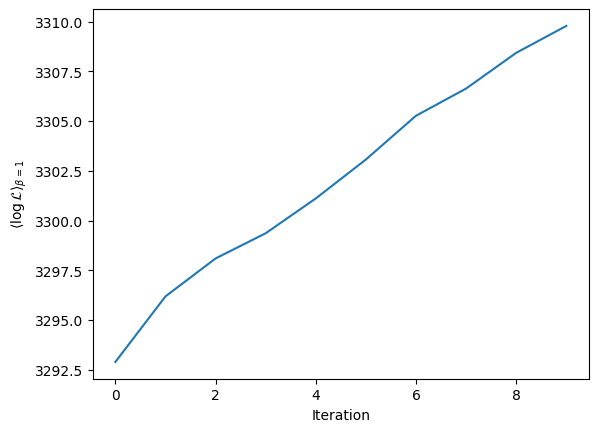

In [86]:
plt.plot(np.mean(chain.logl[:,0,:], axis=1))
plt.xlabel('Iteration')
plt.ylabel(r'$\left\langle \log \mathcal{L} \right\rangle_{\beta=1}$')

Text(0, 0.5, '(teration Mean - Mean)/(Standard Deviation)')

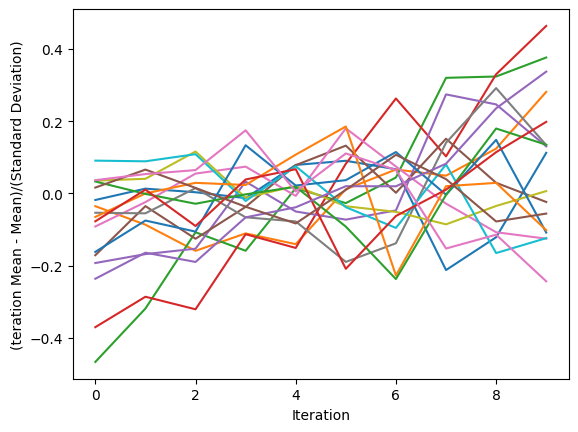

In [79]:
par_means = np.mean(target_samples, axis=(0, 1))
par_stds = np.std(target_samples, axis=(0, 1))
for d in range(target_samples.shape[-1]):
    plt.plot((np.mean(target_samples[:, :, d], axis=1)-par_means[d])/par_stds[d])
plt.xlabel('Iteration')
plt.ylabel('(teration Mean - Mean)/(Standard Deviation)')

In [80]:
chain.betas.shape

(10, 4)

Text(0, 0.5, '$\\beta$')

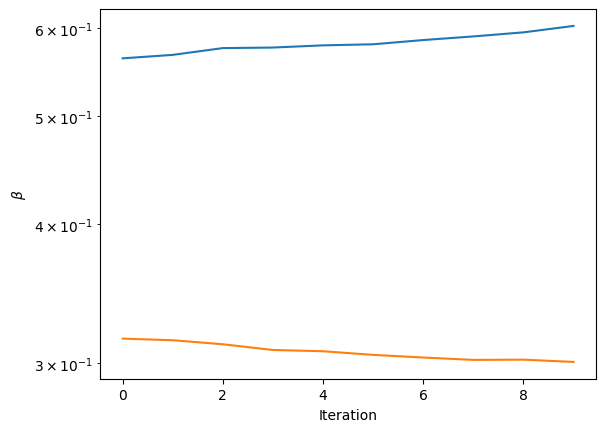

In [81]:
for i in range(1, ntemps-1):
    plt.plot(chain.betas[:,i])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$\beta$')

In [83]:
def get_initial_positions(nwalkers, params):
   param_names = get_free_param_names(params)
   ndim = len(param_names)
   pos = []
   
   for _ in range(nwalkers):
       theta = []
       for name in param_names:
           val = params[name]['truth'] 
           theta.append(val)
       pos.append(theta)
   
   return np.array(pos)

In [54]:
nwalkers=32
initial_positions = get_initial_positions(nwalkers, params)

In [57]:
log_prob = lambda theta: log_probability(theta, chunk_times, chunk_fluxes, chunk_sigmas, params)

In [59]:
likelihood = lambda theta: log_likelihood(theta, chunk_times, chunk_fluxes, chunk_sigmas, params)
prior = lambda theta: log_prior(theta, params)

In [87]:
free

['planet.inc',
 'planet.ecc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'planet.w',
 'star.inc',
 'star.u1',
 'star.u2',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.n',
 'gp.a',
 'gp.b']

In [88]:
theta = np.array([90, 0.2, 4., 2., 2., 6., 90., 0.4, 0.2, 20., 20., 15., 0.5, 10., 0.02, 0.4])  
unpacked = unpack_params(theta, params)

In [58]:
ntemps = 6

In [69]:
import ptemcee
sampler = ptemcee.Sampler(
    nwalkers, 
    ndim, 
    likelihood,     
    prior,         
    ntemps,        
    betas=np.logspace(0, -4, ntemps),   
    # adaptive=True, 
    adaptation_time=10,
    adaptation_lag=100
)

In [84]:
initial_positions = np.array([get_initial_positions(nwalkers, params) for _ in range(ntemps)])

In [78]:
free

['planet.inc',
 'planet.ecc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'planet.w',
 'star.inc',
 'star.u1',
 'star.u2',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.n',
 'gp.a',
 'gp.b']

In [85]:
initial_positions[0,0]

array([8.58584456e+01, 4.81817132e-01, 4.54459216e+00, 2.55651600e+03,
       1.74642623e-01, 1.90000000e+02, 1.15450054e+02, 2.88638000e-01,
       8.50023766e-02, 1.80000000e+01, 6.23148229e+01, 1.16091964e+01,
       4.13210175e-01, 3.31600513e+00, 2.32059437e-02, 1.92721211e-01])

In [86]:
for p, lnprob, lnlike in sampler.sample(initial_positions, iterations=1000):
    pass

ValueError: Attempting to start with samples outside posterior support.